In [18]:
import re
from pathlib import Path
from itertools import combinations
import numpy as np
import pandas as pd
import pyrepseq as prs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [19]:
# Setting paths
data_dir = Path("../Data/20250903 Comparison 1")
output_dir = Path("Final_Figures_and_Sheets_Superset")
output_dir.mkdir(exist_ok=True)

In [20]:
# Confirming epitope-MHC mapping
MHC_MAP = {
    "RTY": "Kb",
    "SNY": "Kb",
    "VGP": "Kb",
    "GYF": "Kd",
    "HFL": "Kd",
    "SYF": "Kd",
}

# Loading files - all Rhapsody CSVs and Sanger Excel
samples = {
    # Sanger data
    "Sanger Data": data_dir / "20250908 Epitope specific TCR LL Sanger.xlsx",
    
    # SYF - Balbc → B10BR (HTx)
    "Balbc-B10BR HTxA Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxA SYF HIL TCR Repertoire.csv",
    "Balbc-B10BR HTxB Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxB SYF HIL TCR Repertoire.csv",
    "Balbc-B10BR HTxC Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxC SYF HIL TCR Repertoire.csv",
    
    # SYF - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxA Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxA SYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxB Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxB SYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxC Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxC SYF LL TCR Repertoire.csv",
    
    # GYF - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxD Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxD GYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxE Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxE GYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxF Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxF GYF LL TCR Repertoire.csv",
    
    # HFL - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxG Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxG HFL LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxH Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxH HFL LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxI Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxI HFL LL TCR Repertoire.csv",
    
    # SYF - Balbc → C57BL6 (HTx)
    "Balbc-C57BL6 HTxA Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxA SYF HIL TCR Repertoire.csv",
    "Balbc-C57BL6 HTxB Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxB SYF HIL TCR Repertoire.csv",
    "Balbc-C57BL6 HTxC Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxC SYF HIL TCR Repertoire.csv",
    
    # SLO Pre-immune controls
    "B10BR SLO": data_dir / "20250903 B10BR Pre-Immune SLO TCR Repertoire.csv",
    "BALBc SLO": data_dir / "20250903 BalbC Pre-Immune SLO TCR Repertoire.csv",
    "C57BL6 SLO": data_dir / "20250903 C57BL6 Pre-Immune SLO TCR Repertoire.csv",
}

In [21]:
def compute_pc(series):
    """Compute probability of coincidence for a series of sequences."""
    counts = series.value_counts().values
    return prs.pc_n(counts)


def compute_pc_grouped_cross_pair(df1, df2, seq_col="CDR3"):
    """Compute pc_grouped_cross between two DataFrames.
    
    Args:
        df1: First DataFrame with sequences
        df2: Second DataFrame with sequences
        seq_col: Column name containing sequences (will fallback to "CDR3" if not found)
        
    Returns:
        float: Cross-sample coincidence probability
    """
    # Determine actual column to use - always prefer "CDR3" as it's created by build_target_column
    def get_col(df, col):
        if col in df.columns:
            return col
        elif "CDR3" in df.columns:
            return "CDR3"
        else:
            raise KeyError(f"Neither {col} nor CDR3 found in DataFrame columns: {df.columns.tolist()}")
    
    col1 = get_col(df1, seq_col)
    col2 = get_col(df2, seq_col)
    
    # Combine with group labels
    df1_tmp = df1[[col1]].copy()
    df1_tmp.columns = ["Seq"]
    df1_tmp["Group"] = "A"
    
    df2_tmp = df2[[col2]].copy()
    df2_tmp.columns = ["Seq"]
    df2_tmp["Group"] = "B"
    
    combined = pd.concat([df1_tmp, df2_tmp], ignore_index=True)
    combined["Seq"] = combined["Seq"].astype(str)
    
    # Compute cross coincidence using pyrepseq
    result = prs.pc_grouped_cross(df=combined, by="Group", on="Seq")
    
    # Return the off-diagonal value (A vs B)
    return result.loc["A", "B"]

In [22]:
def get_seq_column(df, seq_col):
    """Get the appropriate sequence column name from a DataFrame."""
    if seq_col in df.columns:
        return seq_col
    elif seq_col == "CDR3a_aa" and "CDR3a_aa" in df.columns:
        return "CDR3a_aa"
    elif seq_col == "CDR3b_aa" and "CDR3b_aa" in df.columns:
        return "CDR3b_aa"
    elif seq_col == "CDR3" and "CDR3" in df.columns:
        return "CDR3"
    return seq_col

def build_target_column(df, target_col):
    """Normalise CDR3a/CDR3b columns and build a single analysis column.
    
    Supported target_col values:
    - 'CDR3': CDR3a_aa + '_' + CDR3b_aa
    - 'CDR3a': CDR3a_aa only
    - 'CDR3b': CDR3b_aa only
    - 'FullChain': Uses TCRClonotype/Clonotype column (TRAV-CDR3a-TRAJ_TRBV-CDR3b-TRBJ)
    - 'FullAlpha': TRAV + '_' + CDR3a_aa + '_' + TRAJ
    - 'FullBeta': TRBV + '_' + CDR3b_aa + '_' + TRBJ
    """
    df = df.copy()

    # Normalise CDR3 column names
    if "CDR3a_aa" in df.columns:
        pass
    elif "CDR3a" in df.columns:
        df = df.rename(columns={"CDR3a": "CDR3a_aa"})
    
    if "CDR3b_aa" in df.columns:
        pass
    elif "CDR3b" in df.columns:
        df = df.rename(columns={"CDR3b": "CDR3b_aa"})
    
    # Ensure string types for CDR3 columns if they exist
    if "CDR3a_aa" in df.columns:
        df["CDR3a_aa"] = df["CDR3a_aa"].astype(str).replace("nan", "NA")
    if "CDR3b_aa" in df.columns:
        df["CDR3b_aa"] = df["CDR3b_aa"].astype(str).replace("nan", "NA")
    
    # Ensure string types for V/J gene columns if they exist
    for col in ["TRAV", "TRAJ", "TRBV", "TRBJ"]:
        if col in df.columns:
            df[col] = df[col].astype(str).replace("nan", "NA")
    
    # Build the target column based on requested type
    if target_col == "CDR3a":
        if "CDR3a_aa" not in df.columns:
            raise KeyError("Missing CDR3a or CDR3a_aa column")
        df["CDR3"] = df["CDR3a_aa"]
        
    elif target_col == "CDR3b":
        if "CDR3b_aa" not in df.columns:
            raise KeyError("Missing CDR3b or CDR3b_aa column")
        df["CDR3"] = df["CDR3b_aa"]
        
    elif target_col == "CDR3":
        if "CDR3a_aa" not in df.columns or "CDR3b_aa" not in df.columns:
            raise KeyError("Missing CDR3a_aa or CDR3b_aa column")
        df["CDR3"] = df["CDR3a_aa"] + "_" + df["CDR3b_aa"]
        
    elif target_col == "FullChain":
        # Use pre-built clonotype column if available
        if "TCRClonotype" in df.columns:
            df["CDR3"] = df["TCRClonotype"].astype(str).replace("nan", "NA")
        elif "Clonotype" in df.columns:
            df["CDR3"] = df["Clonotype"].astype(str).replace("nan", "NA")
        else:
            # Build from components if clonotype column not available
            required_cols = ["TRAV", "CDR3a_aa", "TRAJ", "TRBV", "CDR3b_aa", "TRBJ"]
            missing = [c for c in required_cols if c not in df.columns]
            if missing:
                raise KeyError(f"Missing columns for FullChain: {missing}")
            df["CDR3"] = (
                df["TRAV"] + "-" + df["CDR3a_aa"] + "-" + df["TRAJ"] + "_" +
                df["TRBV"] + "-" + df["CDR3b_aa"] + "-" + df["TRBJ"]
            )
            
    elif target_col == "FullAlpha":
        required_cols = ["TRAV", "CDR3a_aa", "TRAJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullAlpha: {missing}")
        df["CDR3"] = df["TRAV"] + "_" + df["CDR3a_aa"] + "_" + df["TRAJ"]
        
    elif target_col == "FullBeta":
        required_cols = ["TRBV", "CDR3b_aa", "TRBJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullBeta: {missing}")
        df["CDR3"] = df["TRBV"] + "_" + df["CDR3b_aa"] + "_" + df["TRBJ"]
        
    else:
        raise ValueError("target_col must be 'CDR3a', 'CDR3b', 'CDR3', 'FullChain', 'FullAlpha', or 'FullBeta'")

    return df

In [23]:
def normalise_strain(x):
    """Normalise strain names for consistency."""
    if not isinstance(x, str):
        return x
    x = x.strip()
    x_lower = x.lower()
    if x_lower in ["balbc", "balb/c", "balb c", "balb"]:
        return "BALBc"
    if x_lower in ["b10br", "b10 br", "b10-br"]:
        return "B10BR"
    if x_lower in ["b10brf"]:
        return "B10BRF"
    if x_lower in ["b10brm"]:
        return "B10BRM"
    if x_lower in ["c57bl6", "c57bl/6", "bl6", "c57"]:
        return "C57BL6"
    return x.upper()


def get_recipient_strain_collapsed(strain):
    """Collapse B10BRF/B10BRM to B10BR for grouping purposes."""
    if strain in ["B10BRF", "B10BRM"]:
        return "B10BR"
    return strain

In [24]:
def load_and_process_sanger(filepath, target_col="CDR3"):
    """Load Sanger data and return processed DataFrame with sample metadata."""
    df = pd.read_excel(filepath)
    df = build_target_column(df, target_col)
    
    df.columns = df.columns.str.strip()
    df["Epitope"] = df["Epitope"].astype(str).str.upper().str.strip()
    df["EpitopeRep"] = df["EpitopeRep"].astype(str).str.upper().str.strip()
    df["EpitopeCore"] = df["Epitope"].str[:3]
    df["Rep"] = df["EpitopeRep"].str.extract(r"(\d+)").astype(int)
    df["MHC"] = df["EpitopeCore"].map(MHC_MAP)
    df["Strain"] = df["Strain"].apply(normalise_strain)
    
    # For Sanger data, Strain is the recipient strain
    df["RecipientStrain"] = df["Strain"]
    df["RecipientStrainCollapsed"] = df["RecipientStrain"].apply(get_recipient_strain_collapsed)
    
    # Infer donor strain based on MHC
    def infer_donor(row):
        mhc = row["MHC"]
        recipient = row["RecipientStrain"]
        if mhc == "Kb":
            if recipient in ["BALBc"]:
                return "C57BL6"
            else:  # B10BR, B10BRF, B10BRM
                return "178.3"
        else:  # Kd
            if recipient in ["C57BL6"]:
                return "B6Kd"
            else:  # B10BR, B10BRM
                return "BALBc"
    
    df["DonorStrain"] = df.apply(infer_donor, axis=1)
    
    # Create sample ID
    df["SampleID"] = df["DonorStrain"] + " → " + df["RecipientStrain"] + " | " + df["EpitopeRep"]
    
    return df

In [25]:
def load_and_process_rhapsody(filepath, sample_name, target_col="CDR3"):
    """Load Rhapsody CSV data and return processed DataFrame with sample metadata."""
    df = pd.read_csv(filepath)
    df = build_target_column(df, target_col)
    
    # Parse sample name for metadata
    tokens = sample_name.split()
    
    # Extract donor-recipient
    first = tokens[0]
    if "-" in first:
        donor, recipient = first.split("-")
    else:
        donor, recipient = first, ""
    
    donor = normalise_strain(donor)
    recipient = normalise_strain(recipient)
    
    # Extract graft type
    graft = None
    for t in tokens[1:]:
        if "Tx" in t:
            graft = t
            break
    
    # Extract MHC and epitope
    mhc = None
    epitope_core = None
    for t in tokens:
        m = re.match(r"(K[bd])-([A-Z]{3})", t)
        if m:
            mhc = m.group(1)
            epitope_core = m.group(2)
            break
    
    if epitope_core in MHC_MAP and mhc is None:
        mhc = MHC_MAP[epitope_core]
    
    # Extract tissue type (HIL or LL)
    tissue = None
    for t in tokens:
        if t in ["HIL", "LL"]:
            tissue = t
            break
    
    df["DonorStrain"] = donor
    df["RecipientStrain"] = recipient
    df["RecipientStrainCollapsed"] = get_recipient_strain_collapsed(recipient)
    df["MHC"] = mhc
    df["EpitopeCore"] = epitope_core
    df["Epitope"] = epitope_core
    df["Graft"] = graft
    df["Tissue"] = tissue
    df["SampleID"] = f"{donor} → {recipient} | {graft} | {epitope_core}"
    
    return df

In [26]:
def build_kb_sample_dict(sanger_df):
    """Build dictionary of Kb samples from Sanger data.
    
    Returns dict mapping sample index (1-27) to DataFrame subset.
    Sample ordering (per user specification):
    - RTY: 1-9 (B10BRF 1-3, B10BRM/B10BR 4-6, BALBc 7-9)
    - SNY: 10-18 (same pattern)
    - VGP: 19-27 (same pattern)
    
    Note: B10BR in Sanger data corresponds to B10BRM (male) recipients
          B10BRF corresponds to female recipients
    """
    kb_df = sanger_df[sanger_df["MHC"] == "Kb"].copy()
    
    sample_dict = {}
    idx = 1
    
    for epitope in ["RTY", "SNY", "VGP"]:
        ep_df = kb_df[kb_df["EpitopeCore"] == epitope]
        
        # Order: B10BRF (female), B10BR (male), BALBc
        for strain in ["B10BRF", "B10BR", "BALBc"]:
            strain_df = ep_df[ep_df["RecipientStrain"] == strain]
            
            # Map strain names for display
            if strain == "B10BR":
                display_strain = "B10BRM"  # Male
            else:
                display_strain = strain
            
            for rep in [1, 2, 3]:
                rep_df = strain_df[strain_df["Rep"] == rep]
                if len(rep_df) > 0:
                    sample_dict[idx] = {
                        "df": rep_df,
                        "epitope": epitope,
                        "strain": display_strain,
                        "strain_collapsed": get_recipient_strain_collapsed(display_strain),
                        "rep": rep,
                        "sample_id": f"178.3 → {display_strain} | {epitope}{rep}" if strain != "BALBc" else f"C57BL6 → {display_strain} | {epitope}{rep}"
                    }
                idx += 1
    
    return sample_dict

In [27]:
def build_kd_sample_dict(sanger_df, rhapsody_dfs):
    """Build dictionary of Kd samples from Sanger and Rhapsody data.
    
    Returns dict mapping sample index (1-27) to DataFrame subset.
    Sample ordering based on user specification:
    - GYF: 1-6 (B6Kd→C57BL6 1-3, Balbc→B10BR 4-6)
    - HFL: 7-12 (B6Kd→C57BL6 7-9, Balbc→B10BR 10-12)
    - SYF: 13-27 (complex structure)
    
    Note: We may not have all samples if Rhapsody files are missing.
    """
    kd_sanger = sanger_df[sanger_df["MHC"] == "Kd"].copy()
    
    sample_dict = {}
    
    # Helper finding Rhapsody samples
    def find_rhapsody(keywords, exclude=None):
        results = []
        for name, df in rhapsody_dfs.items():
            if all(kw in name for kw in keywords):
                if exclude is None or not any(ex in name for ex in exclude):
                    results.append((name, df))
        # Sort by name to ensure consistent ordering
        results.sort(key=lambda x: x[0])
        return results
    
    # GYF
    # B6Kd→C57BL6 (Rhapsody SkTxD/E/F)
    gyf_c57_rhapsody = find_rhapsody(["GYF", "C57BL6"]) + find_rhapsody(["GYF", "BL6"])
    # Remove duplicates while preserving order
    seen = set()
    gyf_c57_rhapsody = [(n, d) for n, d in gyf_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 1
        if i < len(gyf_c57_rhapsody):
            name, df = gyf_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "GYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | GYF{i+1}"
            }
    
    # Balbc→B10BR GYF1/2/3 (Sanger)
    gyf_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "GYF"]
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 4
        rep_df = gyf_sanger[(gyf_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (gyf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "GYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | GYF{rep}"
            }
    
    # HFL
    # B6Kd→C57BL6 (Rhapsody SkTxG/H/I)
    hfl_c57_rhapsody = find_rhapsody(["HFL", "C57BL6"]) + find_rhapsody(["HFL", "BL6"])
    seen = set()
    hfl_c57_rhapsody = [(n, d) for n, d in hfl_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 7
        if i < len(hfl_c57_rhapsody):
            name, df = hfl_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "HFL",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | HFL{i+1}"
            }
    
    # Balbc→B10BR HFL1/2/3 (Sanger)
    hfl_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "HFL"]
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 10
        rep_df = hfl_sanger[(hfl_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (hfl_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "HFL",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | HFL{rep}"
            }
    
    # SYF
    syf_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "SYF"]
    
    # B6Kd→C57BL6 SYF1/2/3 (Sanger)
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 13
        rep_df = syf_sanger[(syf_sanger["RecipientStrain"] == "C57BL6") & (syf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": rep,
                "sample_id": f"B6Kd → C57BL6 | SYF{rep}"
            }
    
    # B6Kd→C57BL6 SkTxA/B/C (Rhapsody)
    syf_b6kd_c57_rhapsody = find_rhapsody(["SYF", "B6Kd", "C57BL6"]) + find_rhapsody(["SYF", "B6Kd", "BL6"])
    seen = set()
    syf_b6kd_c57_rhapsody = [(n, d) for n, d in syf_b6kd_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 16
        if i < len(syf_b6kd_c57_rhapsody):
            name, df = syf_b6kd_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | SkTx{chr(65+i)} | SYF"
            }
    
    # Balbc→B10BR HTxA/B/C (Rhapsody)
    syf_balbc_b10_rhapsody = find_rhapsody(["SYF", "Balbc", "B10BR"]) + find_rhapsody(["SYF", "Balbc", "B10"])
    seen = set()
    syf_balbc_b10_rhapsody = [(n, d) for n, d in syf_balbc_b10_rhapsody if n not in seen and not seen.add(n)]
    # Exclude C57BL6/BL6 samples
    syf_balbc_b10_rhapsody = [(n, d) for n, d in syf_balbc_b10_rhapsody if "BL6" not in n and "C57BL6" not in n]
    
    for i in range(3):
        idx = i + 19
        if i < len(syf_balbc_b10_rhapsody):
            name, df = syf_balbc_b10_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"BALBc → B10BR | HTx{chr(65+i)} | SYF"
            }
    
    # Balbc→B10BRM SYF1/2/3 (Sanger)
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 22
        rep_df = syf_sanger[(syf_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (syf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "SYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | SYF{rep}"
            }
    
    # Balbc→C57BL6 HTxA/B/C (Rhapsody)
    syf_balbc_c57_rhapsody = find_rhapsody(["SYF", "Balbc", "C57BL6"]) + find_rhapsody(["SYF", "Balbc", "BL6"])
    seen = set()
    syf_balbc_c57_rhapsody = [(n, d) for n, d in syf_balbc_c57_rhapsody if n not in seen and not seen.add(n)]
    # Exclude B10 samples
    syf_balbc_c57_rhapsody = [(n, d) for n, d in syf_balbc_c57_rhapsody if "B10" not in n]
    
    for i in range(3):
        idx = i + 25
        if i < len(syf_balbc_c57_rhapsody):
            name, df = syf_balbc_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"BALBc → C57BL6 | HTx{chr(65+i)} | SYF"
            }
    
    return sample_dict

In [28]:
def build_supersets(sample_dict, seq_col="CDR3"):
    """Build supersets by combining replicates within each (strain, epitope) group.
    
    For Kb: Groups by (strain, epitope) where strain is B10BRF, B10BRM, or BALBc
    For Kd: Groups by (strain_collapsed, epitope) where strain is C57BL6 or B10BR
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        dict: superset_key -> {
            "df": combined DataFrame,
            "strain": strain name,
            "epitope": epitope name,
            "sample_ids": list of original sample IDs
        }
    """
    # Group samples by (strain, epitope)
    groups = {}
    for idx, sample in sample_dict.items():
        # Use non-collapsed strain for Kb (B10BRF, B10BRM, BALBc)
        # Use collapsed strain for Kd (C57BL6, B10BR)
        strain = sample["strain"]
        epitope = sample["epitope"]
        key = f"{strain}|{epitope}"
        
        if key not in groups:
            groups[key] = {
                "dfs": [],
                "strain": strain,
                "epitope": epitope,
                "sample_ids": []
            }
        
        groups[key]["dfs"].append(sample["df"])
        groups[key]["sample_ids"].append(sample["sample_id"])
    
    # Combine DataFrames within each group
    supersets = {}
    for key, data in groups.items():
        combined_df = pd.concat(data["dfs"], ignore_index=True)
        supersets[key] = {
            "df": combined_df,
            "strain": data["strain"],
            "epitope": data["epitope"],
            "sample_ids": data["sample_ids"],
            "n_samples": len(data["sample_ids"]),
            "n_sequences": len(combined_df)
        }
        print(f"    Superset {key}: {len(data['sample_ids'])} samples, {len(combined_df)} sequences")
    
    return supersets

In [29]:
def compute_level1_individual_pc(sample_dict, seq_col="CDR3"):
    """Level 1: Individual pc for each sample.
    
    Kb: 27 points (9 samples per epitope × 3 epitopes)
    Kd: 27 points
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with pc values for each individual sample
    """
    rows = []
    for idx, sample in sample_dict.items():
        df = sample["df"]
        col = get_seq_column(df, seq_col)
        
        pc = compute_pc(df[col])
        
        rows.append({
            "Level": "L1: within sample",
            "SampleIdx": idx,
            "Epitope": sample["epitope"],
            "Strain": sample["strain"],
            "pc": pc,
            "Index": sample["sample_id"],
            "GroupLabel": sample["epitope"]  # Color by epitope
        })
    
    return pd.DataFrame(rows)

def compute_level2_within_superset_cross(sample_dict, seq_col="CDR3"):
    """Level 2: Pairwise cross-pc between individual samples within each superset.
    
    Within each (strain, epitope) block, compute pairwise cross-pc between replicates.
    
    Kb: 27 points (3 comparisons per superset × 9 supersets)
    Kd: Variable (depends on samples per superset)
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with cross-pc values for each within-superset pair
    """
    rows = []
    
    # Group samples by (strain, epitope)
    groups = {}
    for idx, sample in sample_dict.items():
        strain = sample["strain"]
        epitope = sample["epitope"]
        key = (strain, epitope)
        
        if key not in groups:
            groups[key] = []
        groups[key].append(idx)
    
    # Compute pairwise cross-pc within each group
    for (strain, epitope), indices in groups.items():
        if len(indices) < 2:
            continue
        
        for i, j in combinations(sorted(indices), 2):
            if i not in sample_dict or j not in sample_dict:
                continue
            
            df1 = sample_dict[i]["df"]
            df2 = sample_dict[j]["df"]
            
            pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
            
            rows.append({
                "Level": "L2: within superset\nacross mice",
                "Pair": f"({i},{j})",
                "Epitope": epitope,
                "Strain": strain,
                "pc": pc_cross,
                "Index": f"{strain}|{epitope}",
                "GroupLabel": epitope  # Color by epitope
            })
    
    return pd.DataFrame(rows)

def compute_level3_across_strain_within_epitope(sample_dict, seq_col="CDR3"):
    """Level 3: Superset cross-pc within epitope, across strain.
    
    Build supersets first, then compute cross-pc between supersets with different strains
    but same epitope.
    
    Kb: 9 points (3 strain pairs × 3 epitopes)
    Kd: 3 points (1 strain pair × 3 epitopes)
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with cross-pc values for each across-strain superset pair
    """
    print("  Building supersets for Level 3")
    supersets = build_supersets(sample_dict, seq_col)
    
    rows = []
    
    # Group supersets by epitope
    epitope_groups = {}
    for key, superset in supersets.items():
        epitope = superset["epitope"]
        if epitope not in epitope_groups:
            epitope_groups[epitope] = []
        epitope_groups[epitope].append((key, superset))
    
    # Compute pairwise cross-pc between supersets with different strains
    for epitope, superset_list in epitope_groups.items():
        if len(superset_list) < 2:
            continue
        
        for (key1, ss1), (key2, ss2) in combinations(superset_list, 2):
            # Only compare different strains (should always be true since same strain would be same superset)
            if ss1["strain"] == ss2["strain"]:
                continue
            
            pc_cross = compute_pc_grouped_cross_pair(ss1["df"], ss2["df"], seq_col)
            
            rows.append({
                "Level": "L3: within epitope\nacross strain",
                "Pair": f"{key1} × {key2}",
                "Epitope": epitope,
                "Strain1": ss1["strain"],
                "Strain2": ss2["strain"],
                "pc": pc_cross,
                "Index": epitope,
                "GroupLabel": epitope  # Color by epitope
            })
    
    return pd.DataFrame(rows)

def compute_level4_across_epitope_within_strain(sample_dict, seq_col="CDR3"):
    """Level 4: Superset cross-pc within strain, across epitope.
    
    Build supersets first, then compute cross-pc between supersets with different epitopes
    but same strain.
    
    Kb: 9 points (3 epitope pairs × 3 strains)
    Kd: 6 points (3 epitope pairs × 2 strains)
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with cross-pc values for each across-epitope superset pair
    """
    print("  Building supersets for Level 4")
    supersets = build_supersets(sample_dict, seq_col)
    
    rows = []
    
    # Group supersets by strain
    strain_groups = {}
    for key, superset in supersets.items():
        strain = superset["strain"]
        if strain not in strain_groups:
            strain_groups[strain] = []
        strain_groups[strain].append((key, superset))
    
    # Compute pairwise cross-pc between supersets with different epitopes
    for strain, superset_list in strain_groups.items():
        if len(superset_list) < 2:
            continue
        
        for (key1, ss1), (key2, ss2) in combinations(superset_list, 2):
            # Only compare different epitopes (should always be true)
            if ss1["epitope"] == ss2["epitope"]:
                continue
            
            pc_cross = compute_pc_grouped_cross_pair(ss1["df"], ss2["df"], seq_col)
            
            rows.append({
                "Level": "L4: within strain\nacross epitope",
                "Pair": f"{key1} × {key2}",
                "Strain": strain,
                "Epitope1": ss1["epitope"],
                "Epitope2": ss2["epitope"],
                "pc": pc_cross,
                "Index": strain,
                "GroupLabel": strain  # Color by strain
            })
    
    return pd.DataFrame(rows)

def compute_level5_all_superset_pairs(sample_dict, seq_col="CDR3"):
    """Level 5: All pairwise superset cross-pc.
    
    Build supersets first, then compute cross-pc between all superset pairs.
    
    Kb: 36 points (C(9,2) = 36 pairs from 9 supersets)
    Kd: 15 points (C(6,2) = 15 pairs from 6 supersets)
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with cross-pc values for all superset pairs
    """
    print("  Building supersets for Level 5")
    supersets = build_supersets(sample_dict, seq_col)
    
    rows = []
    
    # Get sorted superset keys
    superset_keys = sorted(supersets.keys())
    
    # Compute all pairwise cross-pc
    for key1, key2 in combinations(superset_keys, 2):
        ss1 = supersets[key1]
        ss2 = supersets[key2]
        
        pc_cross = compute_pc_grouped_cross_pair(ss1["df"], ss2["df"], seq_col)
        
        rows.append({
            "Level": "L5: all supersets",
            "Pair": f"{key1} × {key2}",
            "Strain1": ss1["strain"],
            "Strain2": ss2["strain"],
            "Epitope1": ss1["epitope"],
            "Epitope2": ss2["epitope"],
            "pc": pc_cross,
            "Index": "All",
            "GroupLabel": "All"  # Single color for all
        })
    
    return pd.DataFrame(rows)

def compute_level6_preimmune(slo_dfs, mhc, seq_col="CDR3"):
    """Level 6: Pre-immune repertoire pc values.
    
    Compute individual pc for each SLO sample, plus cross-pc between MHC-appropriate pairs.
    
    Kb: 3 points (B10BR pc, BALBc pc, B10BR × BALBc cross)
    Kd: 3 points (B10BR pc, C57BL6 pc, B10BR × C57BL6 cross)
    
    Args:
        slo_dfs: Dictionary of SLO sample name -> DataFrame
        mhc: 'Kb' or 'Kd' to determine valid cross-comparisons
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with pc values for pre-immune repertoires
    """
    rows = []
    
    # Determine which strains are relevant for this MHC
    if mhc == "Kb":
        relevant_strains = ["B10BR", "BALBc"]
    else:  # Kd
        relevant_strains = ["B10BR", "C57BL6"]
    
    # Filter SLO samples to relevant strains
    relevant_slo = {}
    for name, df in slo_dfs.items():
        for strain in relevant_strains:
            if strain in name:
                relevant_slo[strain] = df
                break
    
    # Compute individual pc for each relevant SLO sample
    for strain, df in relevant_slo.items():
        col = get_seq_column(df, seq_col)
        pc = compute_pc(df[col])
        
        rows.append({
            "Level": "L6: pre-immune",
            "Type": "individual",
            "Strain": strain,
            "pc": pc,
            "Index": f"{strain} SLO",
            "GroupLabel": strain
        })
    
    # Compute cross-pc between the two relevant strains
    if len(relevant_slo) == 2:
        strain_list = list(relevant_slo.keys())
        df1 = relevant_slo[strain_list[0]]
        df2 = relevant_slo[strain_list[1]]
        
        pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
        
        rows.append({
            "Level": "L6: pre-immune",
            "Type": "cross",
            "Strain": f"{strain_list[0]} × {strain_list[1]}",
            "pc": pc_cross,
            "Index": f"{strain_list[0]} × {strain_list[1]}",
            "GroupLabel": "Cross"
        })
    
    return pd.DataFrame(rows)

In [30]:
def build_pc_dataframe(sample_dict, slo_dfs, mhc, seq_col="CDR3"):
    """Build the complete pc DataFrame for all levels.
    
    Levels:
    - L1: Individual sample pc (27 points)
    - L2: Pairwise cross within superset (variable)
    - L3: Superset cross within epitope, across strain (variable)
    - L4: Superset cross within strain, across epitope (variable)
    - L5: All superset pairwise cross (variable)
    - L6: Pre-immune repertoires (3 points)
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        slo_dfs: Dictionary of SLO sample name -> DataFrame
        mhc: 'Kb' or 'Kd'
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with pc values for all levels
    """
    print(f"\nComputing Level 1 for {mhc} (individual sample pc)")
    level1 = compute_level1_individual_pc(sample_dict, seq_col)
    print(f"  Level 1: {len(level1)} points")
    
    print(f"\nComputing Level 2 for {mhc} (within superset, across mice)")
    level2 = compute_level2_within_superset_cross(sample_dict, seq_col)
    print(f"  Level 2: {len(level2)} points")
    
    print(f"\nComputing Level 3 for {mhc} (within epitope, across strain)")
    level3 = compute_level3_across_strain_within_epitope(sample_dict, seq_col)
    print(f"  Level 3: {len(level3)} points")
    
    print(f"\nComputing Level 4 for {mhc} (within strain, across epitope)")
    level4 = compute_level4_across_epitope_within_strain(sample_dict, seq_col)
    print(f"  Level 4: {len(level4)} points")
    
    print(f"\nComputing Level 5 for {mhc} (all superset pairs)")
    level5 = compute_level5_all_superset_pairs(sample_dict, seq_col)
    print(f"  Level 5: {len(level5)} points")
    
    print(f"\nComputing Level 6 for {mhc} (pre-immune repertoires)")
    level6 = compute_level6_preimmune(slo_dfs, mhc, seq_col)
    print(f"  Level 6: {len(level6)} points")
    
    # Combine all levels
    all_levels = pd.concat([level1, level2, level3, level4, level5, level6], ignore_index=True)
    
    return all_levels

In [31]:
def plot_strictness_pc(pc_df, mhc, save_path=None):
    """Plot pc values across strictness levels with mean bars.
    
    Points are aligned in vertical lines by group (epitope/strain).
    Mean bars are positioned over their respective group points.
    Points are lighter colors, mean bars are darker versions.
    
    Args:
        pc_df: DataFrame with pc values from build_pc_dataframe
        mhc: MHC type string for title
        save_path: Optional path to save the figure
    """
    # Define level order
    level_order = [
        "L1: within sample",
        "L2: within superset\nacross mice",
        "L3: within epitope\nacross strain",
        "L4: within strain\nacross epitope",
        "L5: all supersets",
        "L6: pre-immune"
    ]
    
    # Filter to only levels present in data
    level_order = [l for l in level_order if l in pc_df["Level"].values]
    
    # Define color palettes - light versions for points, dark versions for mean bars
    epitope_colors = {
        "RTY": ("#f4a5a5", "#b81c1c"),  # light red, dark red
        "SNY": ("#a5c8e4", "#1c5a8c"),  # light blue, dark blue
        "VGP": ("#a5d6a5", "#2e7d2e"),  # light green, dark green
        "GYF": ("#f4a5a5", "#b81c1c"),  # light red, dark red
        "HFL": ("#a5c8e4", "#1c5a8c"),  # light blue, dark blue
        "SYF": ("#a5d6a5", "#2e7d2e"),  # light green, dark green
    }
    
    strain_colors = {
        "B10BR": ("#d4b8e0", "#6a3d7d"),   # light purple, dark purple
        "B10BRF": ("#e8d4f0", "#8a5d9d"),  # lighter purple, medium purple
        "B10BRM": ("#c4a8d0", "#5a2d6d"),  # medium purple, darker purple
        "BALBc": ("#ffd699", "#cc7000"),   # light orange, dark orange
        "C57BL6": ("#d4b8a0", "#704214"),  # light brown, dark brown
    }
    
    all_colors = {
        "All": ("#c9c9c9", "#555555"),  # light grey, dark grey
    }
    
    preimmune_colors = {
        "B10BR": ("#fdc8b3", "#d45a2a"),    # light coral, dark coral
        "BALBc": ("#b3e0d6", "#2e8b7a"),    # light teal, dark teal
        "C57BL6": ("#c5cee8", "#5a6aa8"),   # light lavender, dark lavender
        "Cross": ("#d9d9d9", "#666666"),    # light grey, dark grey
    }
    
    plt.figure(figsize=(14, 7))
    
    # Plot each level separately to control colors
    all_handles = []
    all_labels = []
    seen_labels = set()
    
    for i, level in enumerate(level_order):
        level_df = pc_df[pc_df["Level"] == level].copy()
        if level_df.empty:
            continue
        
        # Determine color palette for this level
        if level in ["L1: within sample", "L2: within superset\nacross mice", "L3: within epitope\nacross strain"]:
            palette = epitope_colors
        elif level == "L4: within strain\nacross epitope":
            palette = strain_colors
        elif level == "L5: all supersets":
            palette = all_colors
        else:  # L6: pre-immune
            palette = preimmune_colors
        
        # Get unique labels for this level and sort them for consistent positioning
        unique_labels = sorted(level_df["GroupLabel"].dropna().unique())
        n_groups = len(unique_labels)
        
        # Calculate x-offset for each group to spread them out within the level
        if n_groups > 1:
            group_offsets = np.linspace(-0.3, 0.3, n_groups)
        else:
            group_offsets = [0]
        
        label_to_offset = {label: group_offsets[j] for j, label in enumerate(unique_labels)}
        
        # Plot points for each label
        for label in unique_labels:
            label_df = level_df[level_df["GroupLabel"] == label]
            colors = palette.get(label, ("#cccccc", "#333333"))
            light_color = colors[0]
            
            # Position points in a vertical line with small jitter
            base_x = i + label_to_offset[label]
            x_positions = np.random.normal(base_x, 0.03, len(label_df))
            
            # Replace zeros with small epsilon for log scale plotting
            pc_values = label_df["pc"].replace(0, 1e-10)
            
            scatter = plt.scatter(
                x_positions, pc_values, 
                c=light_color, alpha=0.8, s=50,
                edgecolors='white', linewidths=0.5,
                label=label if label not in seen_labels else ""
            )
            
            if label not in seen_labels:
                all_handles.append(scatter)
                all_labels.append(label)
                seen_labels.add(label)
        
        # Add mean bars with darker colors
        if len(level_df) > 0:
            for label in unique_labels:
                group_df = level_df[level_df["GroupLabel"] == label]
                mean_val = group_df["pc"].replace(0, 1e-10).mean()
                colors = palette.get(label, ("#cccccc", "#333333"))
                dark_color = colors[1]
                
                base_x = i + label_to_offset[label]
                bar_half_width = 0.08
                
                plt.hlines(
                    mean_val, base_x - bar_half_width, base_x + bar_half_width,
                    colors=dark_color, linewidth=3, alpha=1.0, zorder=10
                )
    
    plt.yscale("log")
    plt.ylabel("$P_c$", fontsize=12)
    plt.xlabel("")
    plt.title(f"{mhc} Coincidence Probabilities Across Strictness Levels", fontsize=14)
    
    plt.xticks(range(len(level_order)), level_order, rotation=35, ha='right')
    
    # Create legend
    plt.legend(
        all_handles, all_labels,
        bbox_to_anchor=(1.02, 1), loc='upper left',
        fontsize=9, title="Group"
    )
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    plt.close()

In [32]:
def compute_summary_statistics(pc_df, mhc, target_col):
    """Compute average pc per level and ratios between levels.
    
    Args:
        pc_df: DataFrame with pc values from build_pc_dataframe
        mhc: 'Kb' or 'Kd'
        target_col: 'CDR3', 'CDR3a', or 'CDR3b'
        
    Returns:
        DataFrame with summary statistics
    """
    level_order = [
        "L1: within sample",
        "L2: within superset\nacross mice",
        "L3: within epitope\nacross strain",
        "L4: within strain\nacross epitope",
        "L5: all supersets",
        "L6: pre-immune"
    ]
    
    level_order = [l for l in level_order if l in pc_df["Level"].values]
    
    summary_rows = []
    prev_mean = None
    level1_mean = None
    
    for level in level_order:
        level_df = pc_df[pc_df["Level"] == level]
        
        if level_df.empty:
            continue
        
        mean_pc = level_df["pc"].mean()
        median_pc = level_df["pc"].median()
        std_pc = level_df["pc"].std()
        min_pc = level_df["pc"].min()
        max_pc = level_df["pc"].max()
        n_values = len(level_df)
        
        # Store level 1 mean for ratio calculations
        if level1_mean is None:
            level1_mean = mean_pc
        
        # Compute ratio to previous level
        if prev_mean is not None and prev_mean > 0:
            ratio_to_prev = mean_pc / prev_mean
            fold_change = f"{ratio_to_prev:.3f}x"
        else:
            ratio_to_prev = np.nan
            fold_change = "-"
        
        # Compute ratio to level 1
        if level1_mean > 0:
            ratio_to_l1 = mean_pc / level1_mean
            fold_vs_l1 = f"{ratio_to_l1:.3f}x"
        else:
            ratio_to_l1 = np.nan
            fold_vs_l1 = "-"
        
        summary_rows.append({
            "MHC": mhc,
            "Chain": target_col,
            "Level": level,
            "N_Values": n_values,
            "Mean_pc": mean_pc,
            "Median_pc": median_pc,
            "Std_pc": std_pc,
            "Min_pc": min_pc,
            "Max_pc": max_pc,
            "Ratio_to_Previous": ratio_to_prev,
            "Fold_Change": fold_change,
            "Ratio_to_L1": ratio_to_l1,
            "Fold_vs_L1": fold_vs_l1
        })
        
        prev_mean = mean_pc
    
    return pd.DataFrame(summary_rows)

In [33]:
def main():
    """Main execution function."""
    
    results = {}
    all_summaries = []
    
    # Define all sequence column types to process
    # Format: (target_col, seq_col_name, display_name)
    sequence_types = [
        ("CDR3", "CDR3", "CDR3"),
        ("CDR3a", "CDR3a_aa", "CDR3a"),
        ("CDR3b", "CDR3b_aa", "CDR3b"),
        ("FullChain", "CDR3", "FullChain"),
        ("FullAlpha", "CDR3", "FullAlpha"),
        ("FullBeta", "CDR3", "FullBeta"),
    ]
    
    for target_col, seq_col_name, display_name in sequence_types:
        print(f"Processing {display_name}")
        
        # Load Sanger data
        print("\nLoading Sanger data")
        sanger_df = load_and_process_sanger(
            samples["Sanger Data"],
            target_col=target_col
        )
        
        # Load Rhapsody data
        print("Loading Rhapsody data")
        rhapsody_dfs = {}
        slo_dfs = {}
        
        for name, path in samples.items():
            if name == "Sanger Data":
                continue
            if not Path(path).exists():
                print(f"  Skipping {name} - file not found")
                continue
            print(f"  Loading {name}")
            df = load_and_process_rhapsody(path, name, target_col=target_col)
            
            # Separate SLO samples
            if "SLO" in name:
                slo_dfs[name] = df
            else:
                rhapsody_dfs[name] = df
        
        # Build sample dictionaries
        print(f"\nBuilding Kb sample dictionary")
        kb_samples = build_kb_sample_dict(sanger_df)
        print(f"  Found {len(kb_samples)} Kb samples")
        
        print(f"\nBuilding Kd sample dictionary")
        kd_samples = build_kd_sample_dict(sanger_df, rhapsody_dfs)
        print(f"  Found {len(kd_samples)} Kd samples")
        
        # Separate SLO by MHC relevance
        slo_kb = {k: v for k, v in slo_dfs.items() if "BALBc" in k or "B10BR" in k}
        slo_kd = {k: v for k, v in slo_dfs.items() if "C57BL6" in k or "B10BR" in k}
        
        # Process Kb
        print(f"Processing Kb - {display_name}")
        kb_pc_df = build_pc_dataframe(kb_samples, slo_kb, "Kb", seq_col=seq_col_name)
        print(f"\nKb pc DataFrame shape: {kb_pc_df.shape}")
        print(kb_pc_df.groupby("Level").size())
        
        plot_strictness_pc(
            kb_pc_df, f"Kb ({display_name})",
            save_path=output_dir / f"Kb_strictness_pc_{display_name}.svg"
        )
        
        # Compute Kb summary
        kb_summary = compute_summary_statistics(kb_pc_df, "Kb", display_name)
        all_summaries.append(kb_summary)
        
        # Process Kd
        print(f"Processing Kd - {display_name}")
        kd_pc_df = build_pc_dataframe(kd_samples, slo_kd, "Kd", seq_col=seq_col_name)
        print(f"\nKd pc DataFrame shape: {kd_pc_df.shape}")
        print(kd_pc_df.groupby("Level").size())
        
        plot_strictness_pc(
            kd_pc_df, f"Kd ({display_name})",
            save_path=output_dir / f"Kd_strictness_pc_{display_name}.svg"
        )
        
        # Compute Kd summary
        kd_summary = compute_summary_statistics(kd_pc_df, "Kd", display_name)
        all_summaries.append(kd_summary)
        
        # Save DataFrames to Excel
        kb_pc_df.to_excel(output_dir / f"Kb_pc_values_{display_name}.xlsx", index=False)
        kd_pc_df.to_excel(output_dir / f"Kd_pc_values_{display_name}.xlsx", index=False)
        
        # Store results
        results[display_name] = {
            "kb_pc_df": kb_pc_df,
            "kd_pc_df": kd_pc_df,
            "kb_samples": kb_samples,
            "kd_samples": kd_samples,
            "slo_dfs": slo_dfs
        }
    
    # Combine and save all summaries
    summary_df = pd.concat(all_summaries, ignore_index=True)
    summary_df.to_excel(output_dir / "pc_summary_statistics.xlsx", index=False)
    
    # Print summary
    print("SUMMARY: Average Pc and Ratios Between Levels")
    
    for mhc in ["Kb", "Kd"]:
        for chain in ["CDR3", "CDR3a", "CDR3b", "FullChain", "FullAlpha", "FullBeta"]:
            subset = summary_df[(summary_df["MHC"] == mhc) & (summary_df["Chain"] == chain)]
            if len(subset) > 0:
                print(f"\n{mhc} - {chain}:")
                print(subset[["Level", "N_Values", "Mean_pc", "Fold_Change", "Fold_vs_L1"]].to_string(index=False))
    
    print(f"\n\nAll outputs saved to {output_dir}")
    
    return results

Processing CDR3

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for Kb (withi

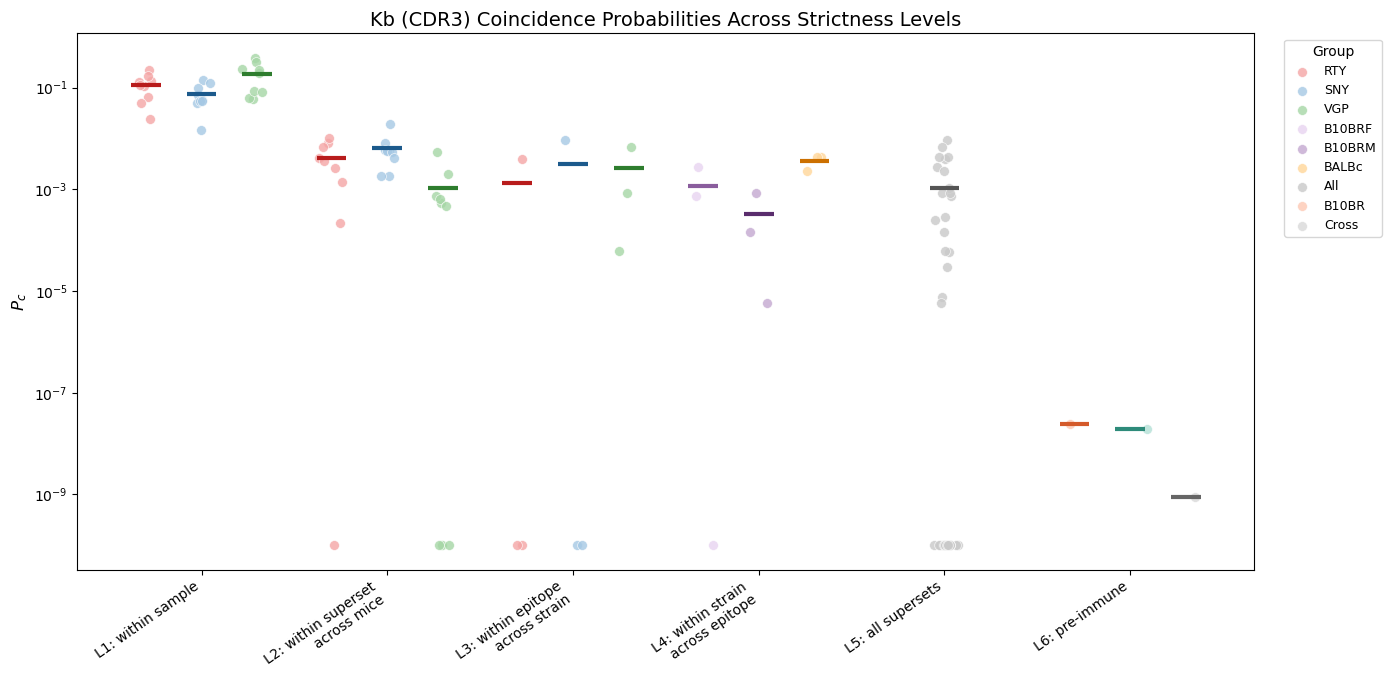

Processing Kd - CDR3

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 points



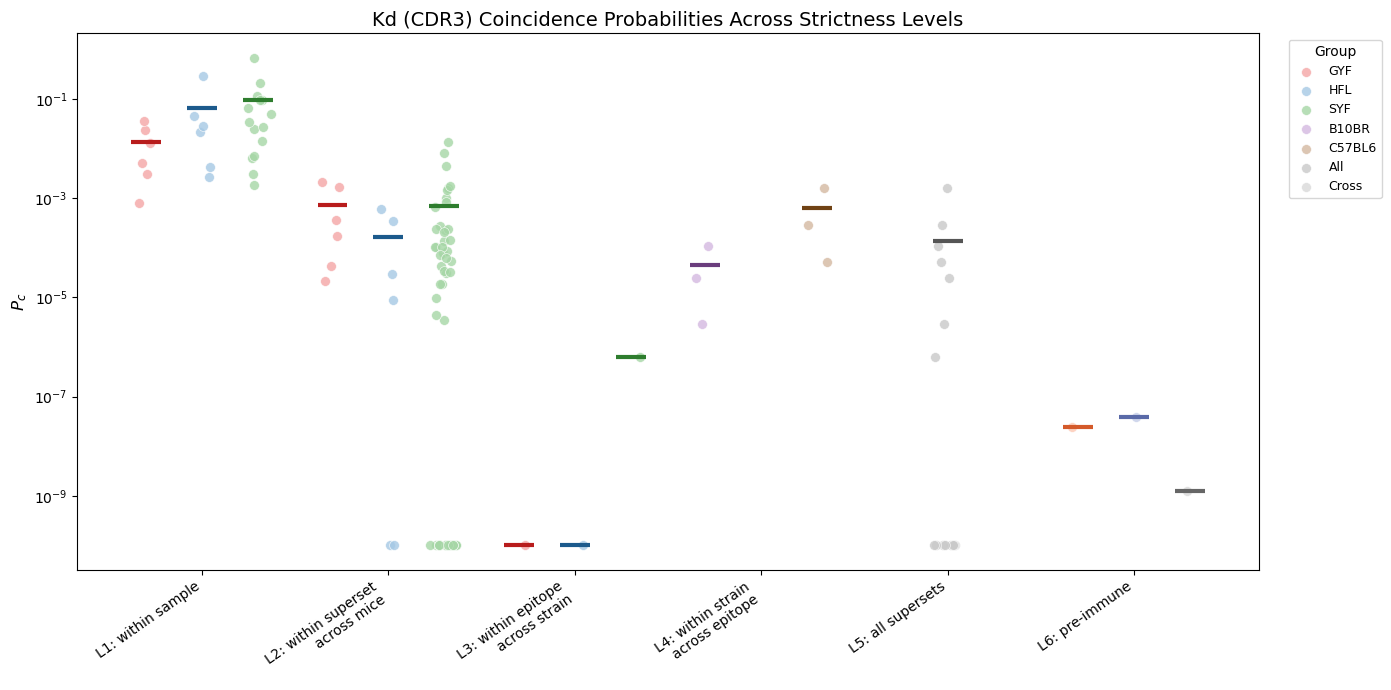

Processing CDR3a

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3a

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for Kb (wit

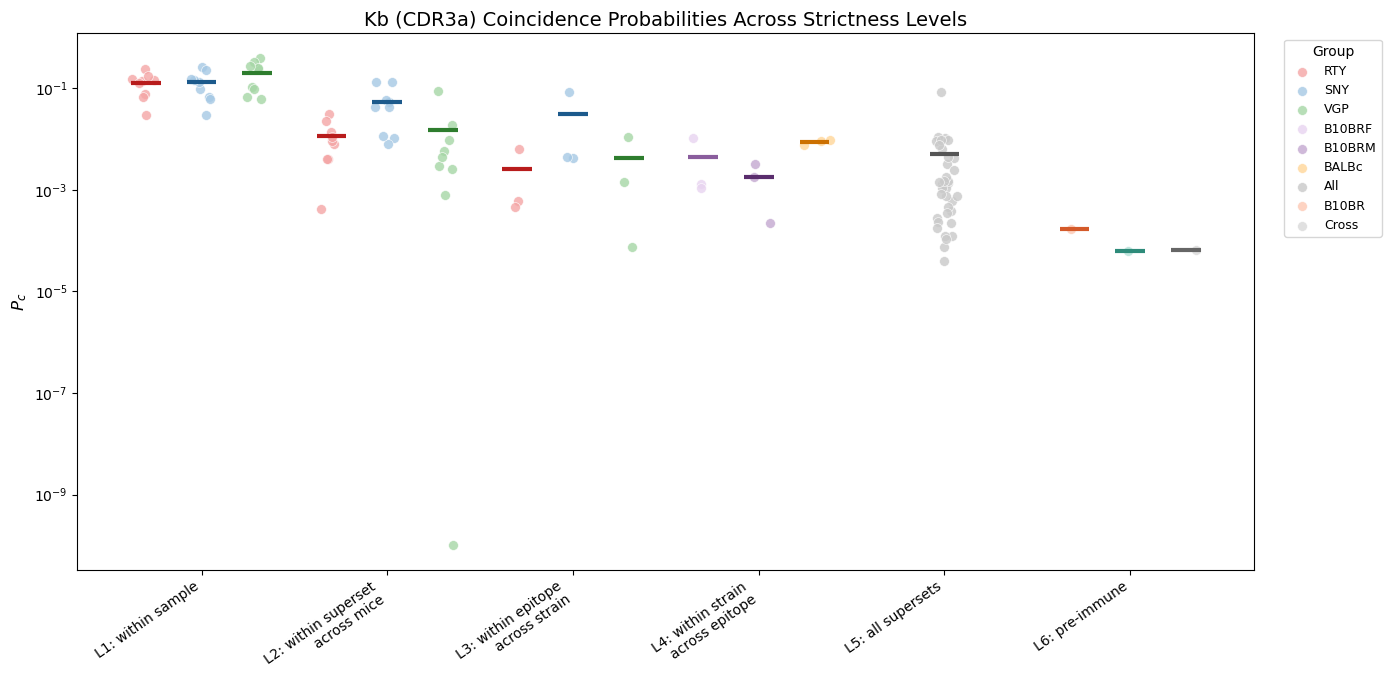

Processing Kd - CDR3a

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 points


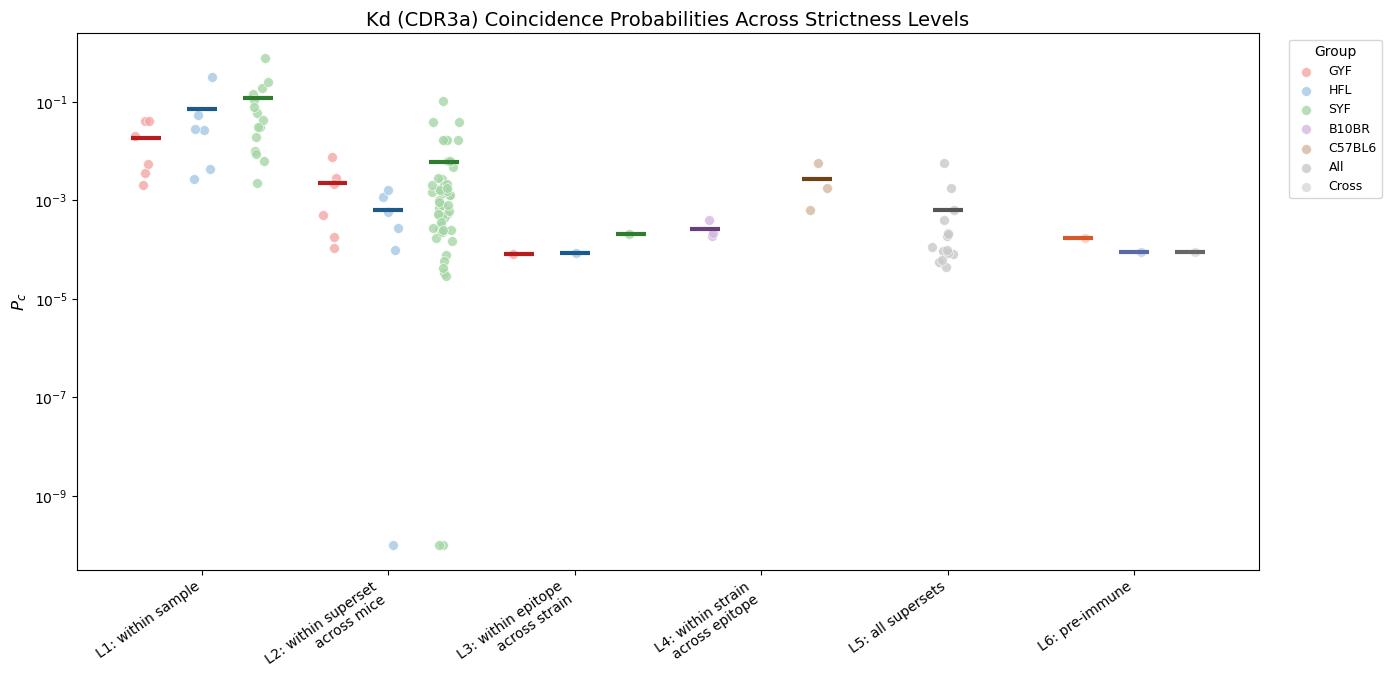

Processing CDR3b

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3b

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for Kb (wit

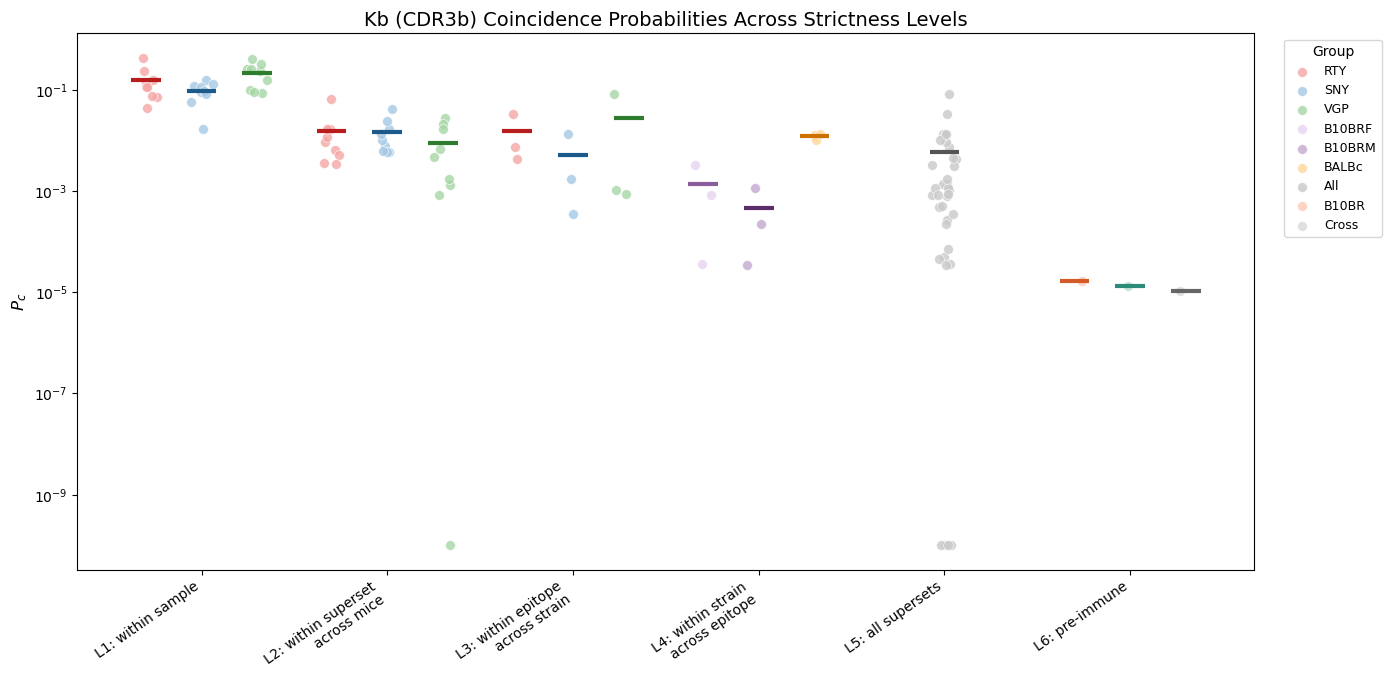

Processing Kd - CDR3b

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 points


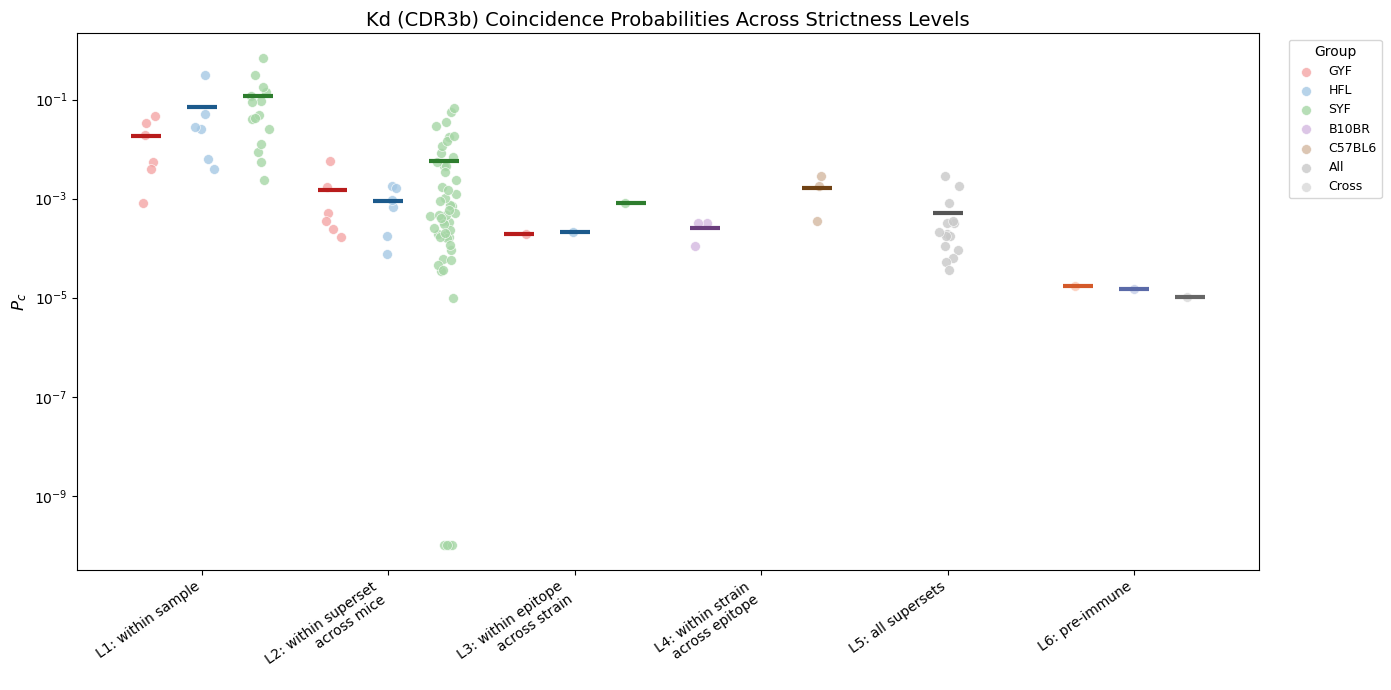

Processing FullChain

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullChain

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for

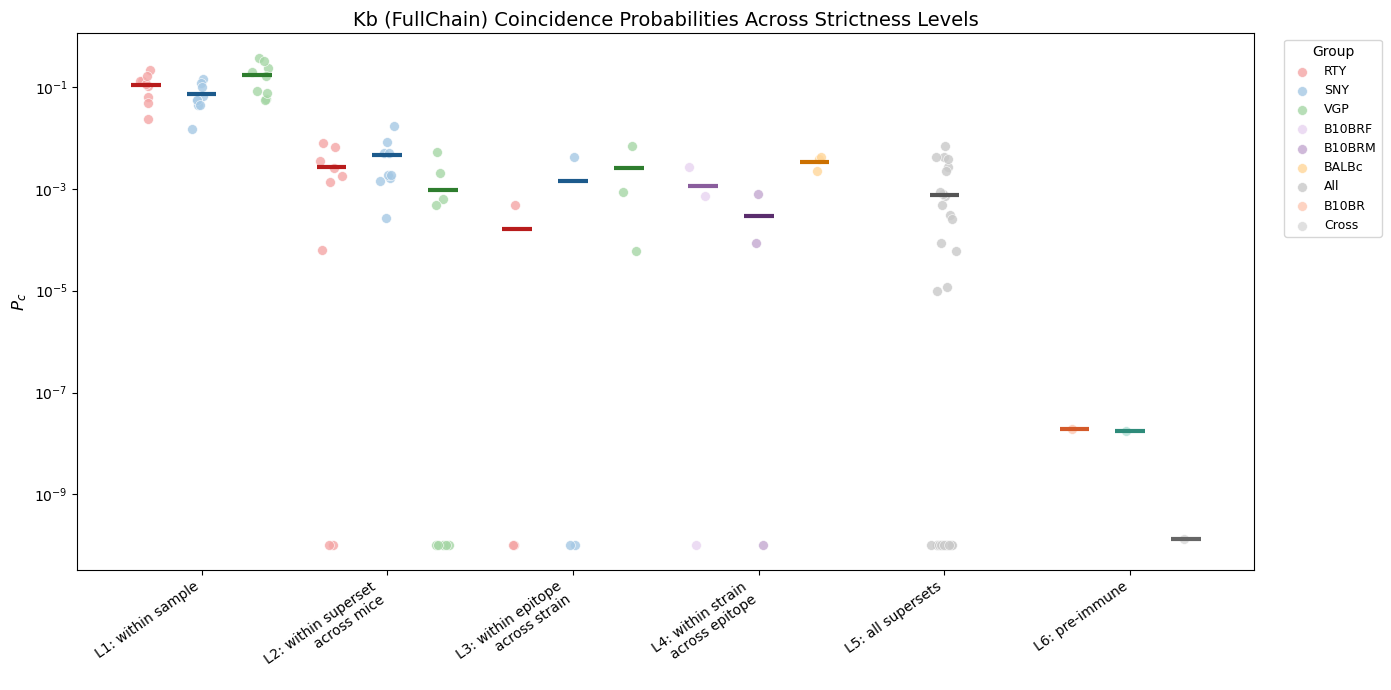

Processing Kd - FullChain

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 poi

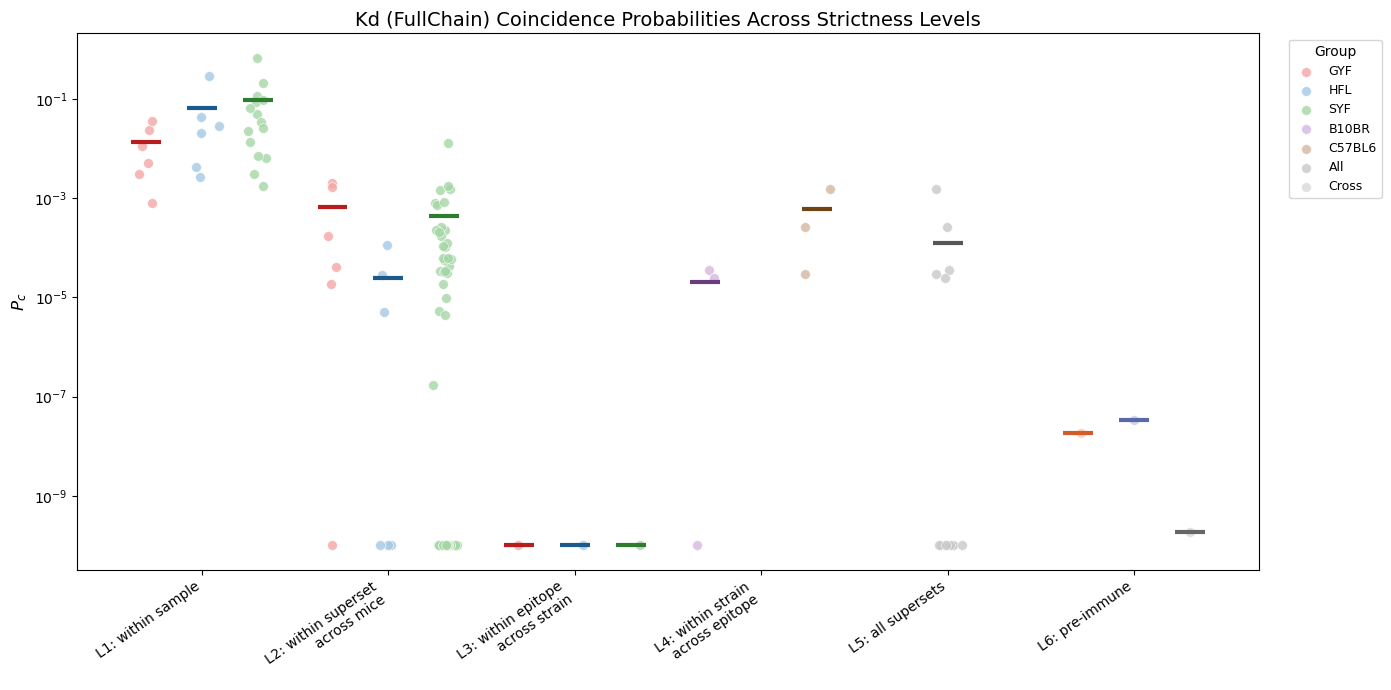

Processing FullAlpha

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullAlpha

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for

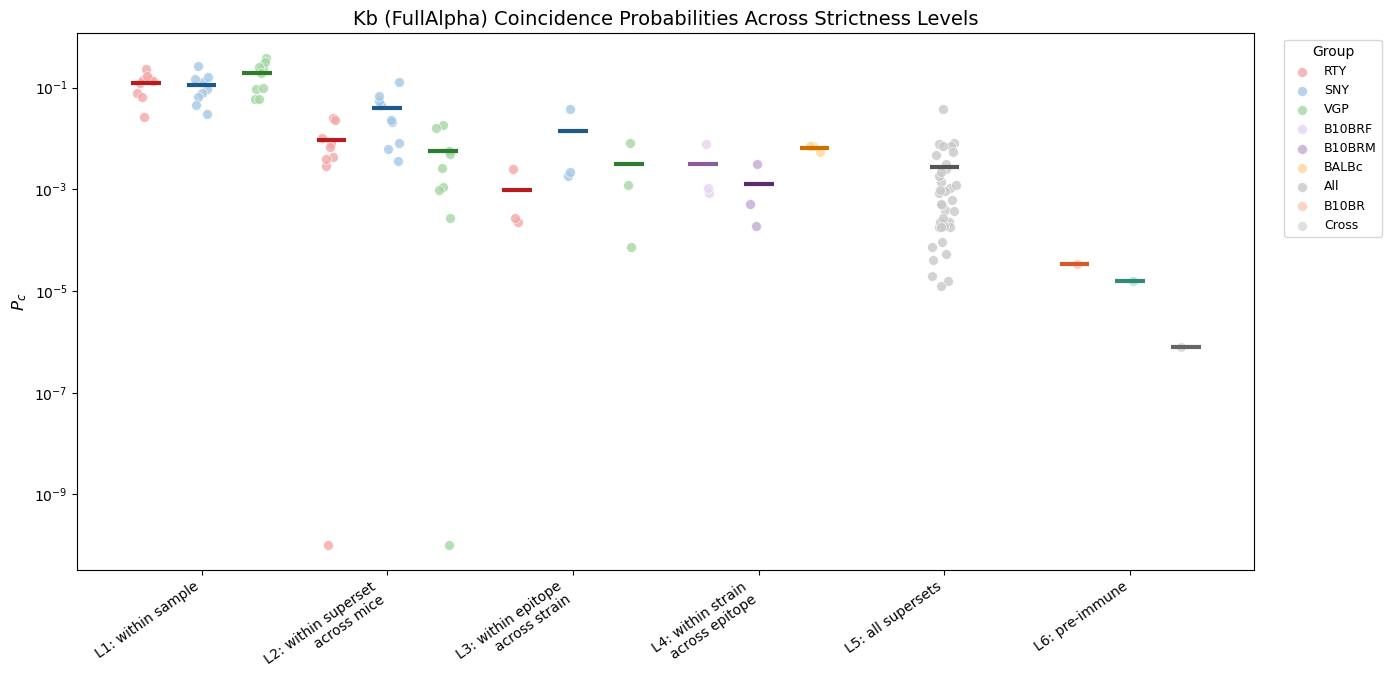

Processing Kd - FullAlpha

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 poi

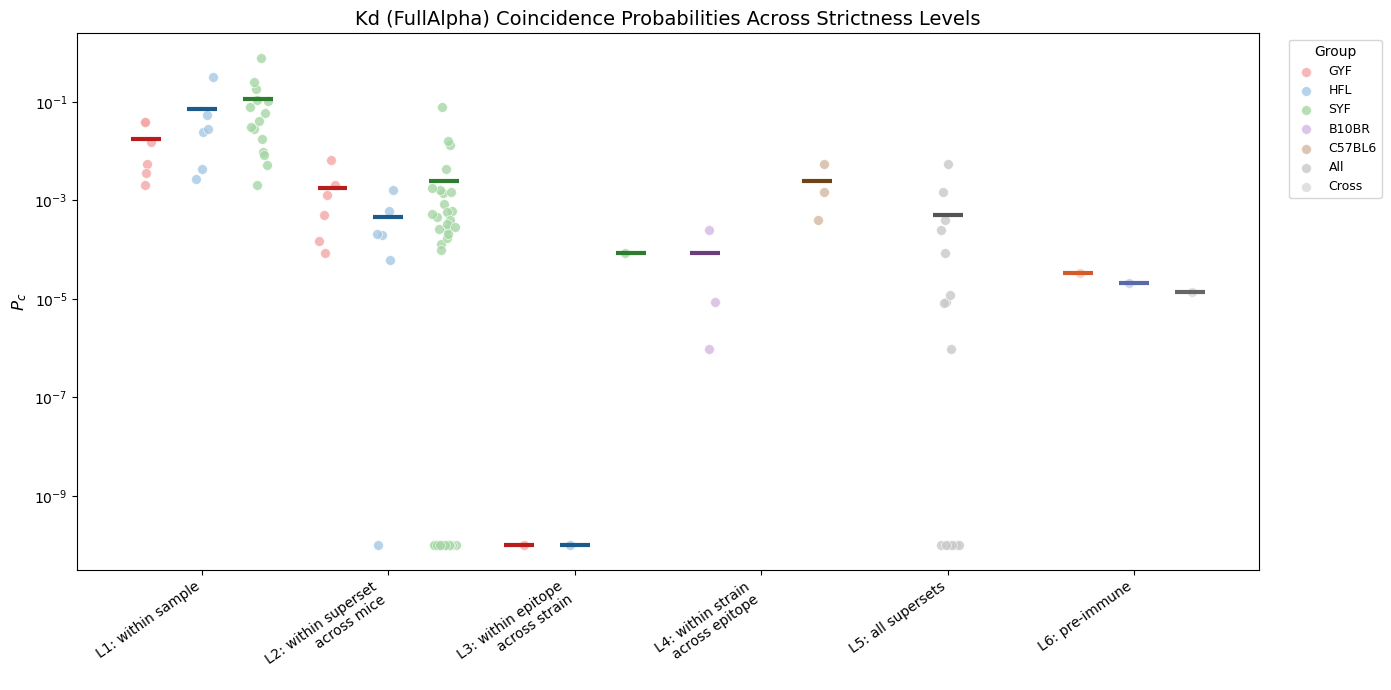

Processing FullBeta

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullBeta

Computing Level 1 for Kb (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kb (within superset, across mice)
  Level 2: 27 points

Computing Level 3 for K

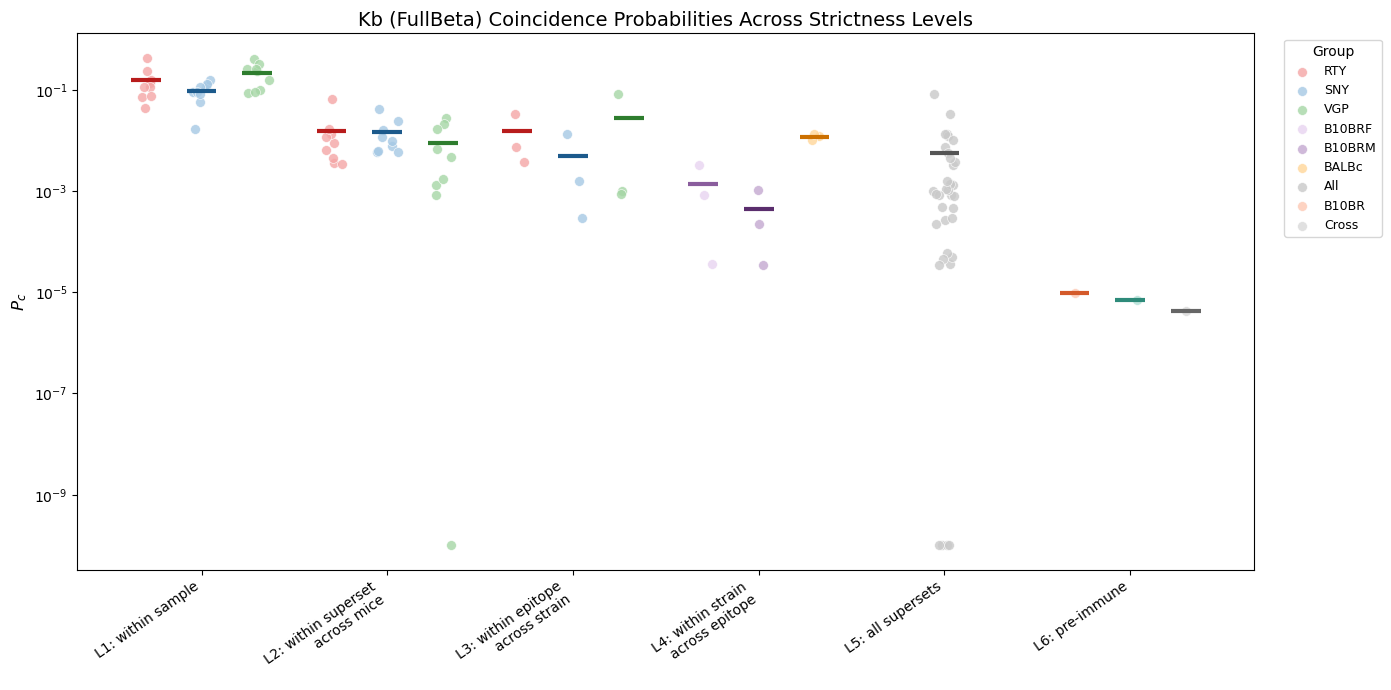

Processing Kd - FullBeta

Computing Level 1 for Kd (individual sample pc)
  Level 1: 27 points

Computing Level 2 for Kd (within superset, across mice)
  Level 2: 63 points

Computing Level 3 for Kd (within epitope, across strain)
  Building supersets for Level 3
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 3: 3 points

Computing Level 4 for Kd (within strain, across epitope)
  Building supersets for Level 4
    Superset C57BL6|GYF: 3 samples, 10253 sequences
    Superset B10BR|GYF: 3 samples, 224 sequences
    Superset C57BL6|HFL: 3 samples, 22336 sequences
    Superset B10BR|HFL: 3 samples, 124 sequences
    Superset C57BL6|SYF: 9 samples, 17046 sequences
    Superset B10BR|SYF: 6 samples, 8428 sequences
  Level 4: 6 poin

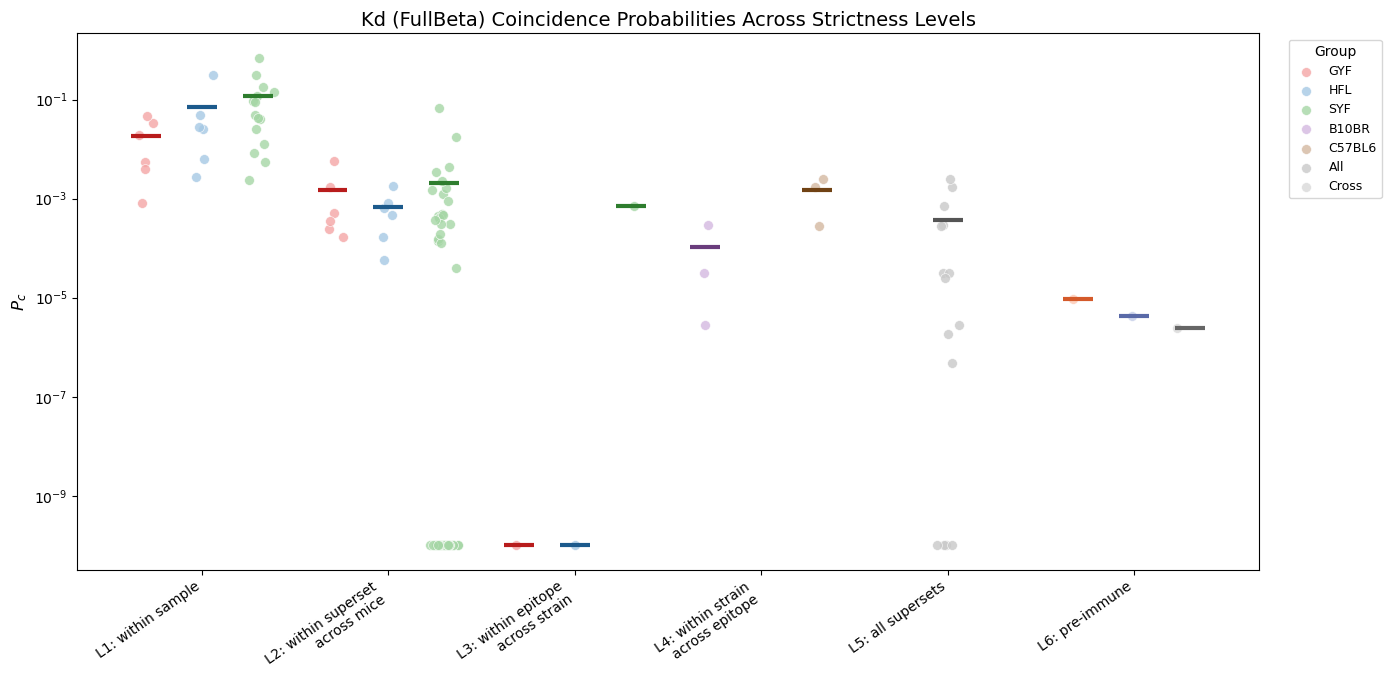

SUMMARY: Average Pc and Ratios Between Levels

Kb - CDR3:
                            Level  N_Values      Mean_pc Fold_Change Fold_vs_L1
                L1: within sample        27 1.233961e-01           -     1.000x
 L2: within superset\nacross mice        27 3.863170e-03      0.031x     0.031x
L3: within epitope\nacross strain         9 2.335630e-03      0.605x     0.019x
L4: within strain\nacross epitope         9 1.714837e-03      0.734x     0.014x
                L5: all supersets        36 1.058866e-03      0.617x     0.009x
                   L6: pre-immune         3 1.486193e-08      0.000x     0.000x

Kb - CDR3a:
                            Level  N_Values  Mean_pc Fold_Change Fold_vs_L1
                L1: within sample        27 0.153521           -     1.000x
 L2: within superset\nacross mice        27 0.027030      0.176x     0.176x
L3: within epitope\nacross strain         9 0.012588      0.466x     0.082x
L4: within strain\nacross epitope         9 0.005005      0.398x 

In [34]:
if __name__ == "__main__":
    results = main()